In [1]:
from DeepMRI import DeepMRI
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import SegAN_IO_arch as SegAN_IO

### Evaluating SeganIO on every dataset modality
This function allows to evaluate a model on a desired dataset. If you are using anything different than SegAN_IO, please import it as "arch"

In [2]:
def evaluate_on(modelname_to_load, checkpoint_to_load, target_datasets, target_mri_types, output_csv, arch=SegAN_IO):
    '''
    Evaluates a given model on a source dataset (the one it has been used for training) and then on a target dataset.
    :param modelname_to_load: The name of the model to load
    :param checkpoint_to_load: Filename of the checkpoint to load. Can be 'last'.
    :param target_dataset: List of dataset names on which evaluate the model
    :param target_mri_type: List of MRI types (as lists) on which evaluate the model.
    :param output_csv: Where to store the results. The csv will contain one row for each evaluated dataset
    '''

    stat_metrics = ['true_positives', 'false_positives', 'false_negatives', 'true_negatives']

    gan = DeepMRI(batch_size=64, size=160, mri_channels=len(target_mri_types[0]), model_name=modelname_to_load)
    gan.build_model(load_model=gan.save_path+checkpoint_to_load, seed=1234567890, arch=arch)

    eval_log = pd.DataFrame()
    runs = pd.DataFrame()
    for target_dataset, target_mri_type in zip(target_datasets, target_mri_types):
        print("\nEvaluating on {}-{}".format(target_dataset, ','.join(target_mri_type)))
        gan.load_dataset(dataset=target_dataset, mri_types=target_mri_type)
        per_slice_stats = gan.evaluate(output_csv, mri_types=target_mri_type, dataset='testing')
        per_slice_stats['Target Dataset'] = target_dataset
        per_slice_stats['Target Modality'] = ' '.join([t.replace('MR_', '') for t in target_mri_type])

        per_mri_stats = per_slice_stats.groupby(['path_' + t for t in target_mri_type] + ['run', 'model', 'Target Dataset', 'Target Modality'])[stat_metrics].sum()
        per_mri_stats['dice_score'] = 2.0*per_mri_stats['true_positives']/(2.0*per_mri_stats['true_positives'] + per_mri_stats['false_positives'] + per_mri_stats['false_negatives'])
        per_mri_stats['precision'] = per_mri_stats['true_positives']/(per_mri_stats['true_positives'] + per_mri_stats['false_positives'])
        per_mri_stats['sensitivity'] = per_mri_stats['true_positives']/(per_mri_stats['true_positives'] + per_mri_stats['false_negatives'])

        run_performance = per_mri_stats.reset_index().groupby(['model', 'run', 'Target Dataset', 'Target Modality']).mean()[['dice_score', 'precision', 'sensitivity']]
        runs = runs.append(run_performance)
        
    runs.to_csv(output_csv)
    print("Output saved to {}".format(output_csv))
    
def plot_csv(output_csv, metrics=['dice_score', 'precision', 'sensitivity']):
    log = pd.read_csv(output_csv, usecols=metrics + ['dataset', 'mri_types'])
    log = log.set_index(['dataset', 'mri_types'])
    stacked = log.stack()
    stacked = stacked.rename_axis(index=['dataset', 'modality', 'metric'])
    logdata = stacked.reset_index()
    logdata = logdata.rename(columns={0:'value'})
    plt.figure(figsize=(30,20))
    sb.catplot(data=logdata, col='metric', col_wrap=3, hue='dataset', x='modality', y="value", kind='bar', sharex=False)
    plt.show()
    
def compare_models(output_csv, model_names, source_ds, source_mod, show_relative_performances, metrics=['dice_score', 'precision', 'sensitivity'], save_path=None):
    df = None
    val_column_name = 'rel_performance' if show_relative_performances else 'value'
    for csv, model_name, src_ds, src_mod in zip(output_csv, model_names, source_ds, source_mod):
        log = pd.read_csv(csv, usecols=metrics + ['Target Dataset', 'Target Modality'])
        log['model'] = model_name
        log = log.set_index(['model', 'Target Dataset', 'Target Modality'])
        if show_relative_performances:
            log = log / log.loc[model_name].loc[src_ds].loc[src_mod]
        stacked = log.stack()
        stacked = stacked.rename_axis(index=['model','Target Dataset', 'Target Modality', 'metric'])

        logdata = stacked.reset_index()
        logdata = logdata.rename(columns={0:val_column_name})
        # Merge dataset and modality for visualization
        logdata['dataset_and_modality'] = logdata['Target Dataset']+ '_' +logdata['Target Modality']
        
        if df is None:
            df = logdata
        else:
            df = df.append(logdata, ignore_index=True)
    sb.set_style("whitegrid")
    sb.set_context("paper", font_scale=2)
    
    if len(metrics)==1:
        # This is for showing the metric name on y axis
        metric_name = metrics[0].replace('_', ' ')
        temp = df.rename(columns={'value': metric_name})
        plot = sb.catplot(data=temp, x='Target Modality', y=metric_name, col='model', kind='bar', col_wrap=2, sharex=False)
    else:
        plot = sb.catplot(data=df, x='Target Modality', y=val_column_name, row='metric', col='model', kind='bar')
    #plot.set_xticklabels(rotation = 90, ha="right")
    plot.add_legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return df

target_datasets = ['brats', 'brats', 'brats', 'brats']
target_mri_types = [['MR_T1'],['MR_T1c'],['MR_T2'], ['MR_Flair']]

#### Evaluating models trained on BRATS

In [3]:
evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T1", 
            checkpoint_to_load = 'best_dice_score_861-45', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/Segan_IO_TF2_brats_on_T1_base_performances.csv')


evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T1c", 
            checkpoint_to_load = 'best_dice_score_1011-48', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/Segan_IO_TF2_brats_on_T1c_base_performances.csv')


evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_T2", 
            checkpoint_to_load = 'best_dice_score_182-25', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/Segan_IO_TF2_brats_on_T2_base_performances.csv')

evaluate_on(modelname_to_load = "Segan_IO_TF2_brats_on_FLAIR", 
            checkpoint_to_load = 'best_dice_score_168-29', 
            target_datasets = target_datasets, 
            target_mri_types = target_mri_types, 
            output_csv = 'results/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv')


Using architecture: SegAN_IO_arch
Loaded history from models/Segan_IO_TF2_brats_on_T1/log_train.csv
Loaded history from models/Segan_IO_TF2_brats_on_T1/log_valid.csv
Loading models/Segan_IO_TF2_brats_on_T1/best_dice_score_861-45
Loaded model from: models/Segan_IO_TF2_brats_on_T1/best_dice_score_861-45, next epoch: 1127

Evaluating on brats-MR_T1
Loading dataset brats with modalities MR_T1
Done.
     55/Unknown - 19s 345ms/step - loss_g: 1.3906 - loss_d: -0.4246 - sensitivity: 0.1264 - specificity: 0.9994 - false_positive_rate: 5.8075e-04 - precision: 0.8149 - dice_score: 0.0496 - balanced_accuracy: 0.5629 - smooth_dice_loss: 0.9661 - mae: 0.0384 - true_positives: 1.5469 - false_positives: 14.7656 - false_negatives: 967.8281 - true_negatives: 24615.8594  
Evaluating on brats-MR_T1c
Unloading previous dataset
Loading dataset brats with modalities MR_T1c
Done.
     55/Unknown - 14s 259ms/step - loss_g: 1.2394 - loss_d: -0.3812 - sensitivity: 0.1348 - specificity: 0.9999 - false_positive_r

W1115 14:10:29.690930 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.iter
W1115 14:10:29.692308 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.decay
W1115 14:10:29.693344 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.learning_rate
W1115 14:10:29.694310 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.momentum
W1115 14:10:29.695253 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.rho
W1115 14:10:29.696201 139898107295552 util.py:252] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/che

Loaded history from models/Segan_IO_TF2_brats_on_T1c/log_train.csv
Loaded history from models/Segan_IO_TF2_brats_on_T1c/log_valid.csv
Loading models/Segan_IO_TF2_brats_on_T1c/best_dice_score_1011-48
Loaded model from: models/Segan_IO_TF2_brats_on_T1c/best_dice_score_1011-48, next epoch: 1439

Evaluating on brats-MR_T1
Loading dataset brats with modalities MR_T1
Done.
     55/Unknown - 14s 260ms/step - loss_g: 1.4164 - loss_d: -0.4164 - sensitivity: 0.1250 - specificity: 0.9976 - false_positive_rate: 0.0024 - precision: 0.7500 - dice_score: 0.0000e+00 - balanced_accuracy: 0.5613 - smooth_dice_loss: 1.0000 - mae: 0.0403 - true_positives: 0.0000e+00 - false_positives: 61.9844 - false_negatives: 969.3750 - true_negatives: 24568.6406
Evaluating on brats-MR_T1c
Unloading previous dataset
Loading dataset brats with modalities MR_T1c
Done.
     55/Unknown - 14s 256ms/step - loss_g: 1.3906 - loss_d: -0.3951 - sensitivity: 0.1274 - specificity: 0.9977 - false_positive_rate: 0.0023 - precision: 0

W1115 14:11:34.616347 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.iter
W1115 14:11:34.617746 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.decay
W1115 14:11:34.618736 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.learning_rate
W1115 14:11:34.619588 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.momentum
W1115 14:11:34.620457 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.rho
W1115 14:11:34.621338 139898107295552 util.py:252] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/che

Loaded history from models/Segan_IO_TF2_brats_on_T2/log_train.csv
Loaded history from models/Segan_IO_TF2_brats_on_T2/log_valid.csv
Loading models/Segan_IO_TF2_brats_on_T2/best_dice_score_182-25
Loaded model from: models/Segan_IO_TF2_brats_on_T2/best_dice_score_182-25, next epoch: 666

Evaluating on brats-MR_T1
Loading dataset brats with modalities MR_T1
Done.
     55/Unknown - 14s 259ms/step - loss_g: 1.4701 - loss_d: -0.5542 - sensitivity: 0.4392 - specificity: 0.8375 - false_positive_rate: 0.1625 - precision: 0.4736 - dice_score: 0.0837 - balanced_accuracy: 0.6383 - smooth_dice_loss: 0.9158 - mae: 0.1879 - true_positives: 249.4531 - false_positives: 4088.2344 - false_negatives: 719.9219 - true_negatives: 20542.3906    
Evaluating on brats-MR_T1c
Unloading previous dataset
Loading dataset brats with modalities MR_T1c
Done.
     55/Unknown - 14s 254ms/step - loss_g: 1.3921 - loss_d: -0.4432 - sensitivity: 0.3501 - specificity: 0.8891 - false_positive_rate: 0.1109 - precision: 0.5226 -

W1115 14:12:57.532659 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.iter
W1115 14:12:57.534003 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.decay
W1115 14:12:57.534994 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.learning_rate
W1115 14:12:57.535838 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.momentum
W1115 14:12:57.536725 139898107295552 util.py:244] Unresolved object in checkpoint: (root).d_optimizer.rho
W1115 14:12:57.537614 139898107295552 util.py:252] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/che

     55/Unknown - 14s 262ms/step - loss_g: 1.2967 - loss_d: -0.3016 - sensitivity: 0.1923 - specificity: 0.9651 - false_positive_rate: 0.0349 - precision: 0.6900 - dice_score: 0.0048 - balanced_accuracy: 0.5787 - smooth_dice_loss: 0.9952 - mae: 0.0724 - true_positives: 9.0625 - false_positives: 891.3906 - false_negatives: 960.3125 - true_negatives: 23739.2344       
Evaluating on brats-MR_T2
Unloading previous dataset
Loading dataset brats with modalities MR_T2
Done.
     55/Unknown - 14s 254ms/step - loss_g: 0.7744 - loss_d: -0.2082 - sensitivity: 0.5996 - specificity: 0.9721 - false_positive_rate: 0.0279 - precision: 0.5555 - dice_score: 0.4319 - balanced_accuracy: 0.7858 - smooth_dice_loss: 0.5662 - mae: 0.0431 - true_positives: 567.6094 - false_positives: 700.8594 - false_negatives: 401.7656 - true_negatives: 23929.7656    
Evaluating on brats-MR_Flair
Unloading previous dataset
Loading dataset brats with modalities MR_Flair
Done.
     55/Unknown - 14s 254ms/step - loss_g: 0.1881 -

#### Visualize performances of every model against every dataset
output_csv contains the list of csv generated in the previous secion. Fill source_ds and source_mod with the corresponding dataset and modality the model has been trained on.

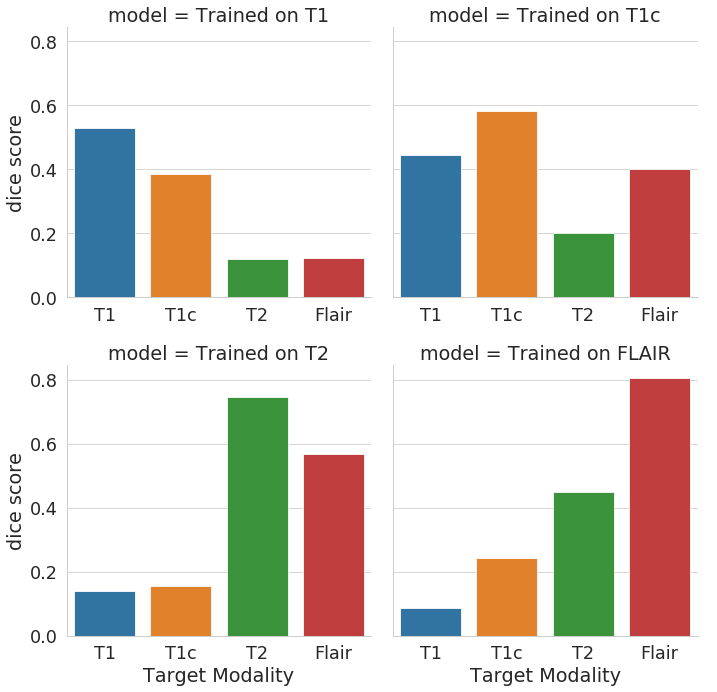

In [5]:
#Show base models
output_csv = ["results/Segan_IO_TF2_brats_on_T1_base_performances.csv", 
              "results/Segan_IO_TF2_brats_on_T1c_base_performances.csv", 
              "results/Segan_IO_TF2_brats_on_T2_base_performances.csv",
              "results/Segan_IO_TF2_brats_on_FLAIR_base_performances.csv"]
model_names = ["Trained on T1",
               "Trained on T1c",
               "Trained on T2",
               "Trained on FLAIR"]
source_ds = ['brats', 'brats', 'brats', 'brats']
source_mod = ['MR_T1', 'MR_T1c', 'MR_T2', 'MR_Flair']
performances = compare_models(output_csv, model_names, source_ds, source_mod,metrics=['dice_score'], show_relative_performances=False, save_path='results/base_performances.png')

In [29]:
performances

,model,dataset,modality,metric,dice score,dataset_and_modality
0,SegAN_IO-T1,brats,MR_T1,dice_score,0.561918,brats_MR_T1
1,SegAN_IO-T1,brats,MR_T1c,dice_score,0.403286,brats_MR_T1c
2,SegAN_IO-T1,brats,MR_T2,dice_score,0.118884,brats_MR_T2
3,SegAN_IO-T1,brats,MR_Flair,dice_score,0.122261,brats_MR_Flair
4,SegAN_IO-T1c,brats,MR_T1,dice_score,0.480998,brats_MR_T1
5,SegAN_IO-T1c,brats,MR_T1c,dice_score,0.632689,brats_MR_T1c
6,SegAN_IO-T1c,brats,MR_T2,dice_score,0.196240,brats_MR_T2
7,SegAN_IO-T1c,brats,MR_Flair,dice_score,0.409641,brats_MR_Flair
8,SegAN_IO-T2,brats,MR_T1,dice_score,0.141650,brats_MR_T1
9,SegAN_IO-T2,brats,MR_T1c,dice_score,0.152520,brats_MR_T1c
